# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
    transforms.RandomRotation((-3.0, 3.0), fill=(1,)),  # Very conservative rotation
    transforms.RandomAffine(
        degrees=0,
        translate=(0.05, 0.05),  # Reduced translation
        scale=(0.98, 1.02),     # Minimal scaling
        shear=(-2, 2),          # Minimal shear
        fill=(1,)
    ),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [11]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [12]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=156, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [13]:
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 10

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 8

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 8

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 8

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [14]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]              64
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 14, 10, 10]           1,008
             ReLU-12           [-1, 14, 10, 10]               0
      BatchNorm2d-13           [-1, 14, 10, 10]              28
          Dropout-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [15]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        test_accuracy))

    test_acc.append(100. * correct / len(test_loader.dataset))
    return test_accuracy

In [16]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=8, gamma=0.1)


EPOCHS = 15
best_acc = 0
for epoch in range(EPOCHS):
    print("\n======= EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test_accuracy = test(model, device, test_loader)

    if test_accuracy > best_acc:
        best_acc = test_accuracy
    print(f'>>> Best Test Accuracy: {best_acc:.2f}%')


======= EPOCH: 0


Loss=0.1675458550453186 Batch_id=384 Accuracy=92.01: 100%|██████████| 385/385 [00:27<00:00, 13.92it/s]



Test set: Average loss: 0.1136, Accuracy: 9781/10000 (97.81%)

>>> Best Test Accuracy: 97.81%

======= EPOCH: 1


Loss=0.10550472140312195 Batch_id=384 Accuracy=97.46: 100%|██████████| 385/385 [00:19<00:00, 19.67it/s]



Test set: Average loss: 0.0571, Accuracy: 9866/10000 (98.66%)

>>> Best Test Accuracy: 98.66%

======= EPOCH: 2


Loss=0.07533743232488632 Batch_id=384 Accuracy=97.92: 100%|██████████| 385/385 [00:22<00:00, 17.47it/s]



Test set: Average loss: 0.0540, Accuracy: 9865/10000 (98.65%)

>>> Best Test Accuracy: 98.66%

======= EPOCH: 3


Loss=0.08413476496934891 Batch_id=384 Accuracy=98.19: 100%|██████████| 385/385 [00:22<00:00, 17.45it/s]



Test set: Average loss: 0.0409, Accuracy: 9902/10000 (99.02%)

>>> Best Test Accuracy: 99.02%

======= EPOCH: 4


Loss=0.04535758122801781 Batch_id=384 Accuracy=98.35: 100%|██████████| 385/385 [00:21<00:00, 18.22it/s]



Test set: Average loss: 0.0341, Accuracy: 9908/10000 (99.08%)

>>> Best Test Accuracy: 99.08%

======= EPOCH: 5


Loss=0.11081478744745255 Batch_id=384 Accuracy=98.49: 100%|██████████| 385/385 [00:21<00:00, 17.81it/s]



Test set: Average loss: 0.0286, Accuracy: 9929/10000 (99.29%)

>>> Best Test Accuracy: 99.29%

======= EPOCH: 6


Loss=0.08040886372327805 Batch_id=384 Accuracy=98.53: 100%|██████████| 385/385 [00:21<00:00, 18.02it/s]



Test set: Average loss: 0.0266, Accuracy: 9928/10000 (99.28%)

>>> Best Test Accuracy: 99.29%

======= EPOCH: 7


Loss=0.06982223689556122 Batch_id=384 Accuracy=98.68: 100%|██████████| 385/385 [00:21<00:00, 17.79it/s]



Test set: Average loss: 0.0285, Accuracy: 9920/10000 (99.20%)

>>> Best Test Accuracy: 99.29%

======= EPOCH: 8


Loss=0.028558194637298584 Batch_id=384 Accuracy=98.83: 100%|██████████| 385/385 [00:21<00:00, 18.23it/s]



Test set: Average loss: 0.0231, Accuracy: 9942/10000 (99.42%)

>>> Best Test Accuracy: 99.42%

======= EPOCH: 9


Loss=0.04428687319159508 Batch_id=384 Accuracy=98.94: 100%|██████████| 385/385 [00:22<00:00, 17.50it/s]



Test set: Average loss: 0.0234, Accuracy: 9939/10000 (99.39%)

>>> Best Test Accuracy: 99.42%

======= EPOCH: 10


Loss=0.03186566382646561 Batch_id=384 Accuracy=98.91: 100%|██████████| 385/385 [00:22<00:00, 16.97it/s]



Test set: Average loss: 0.0225, Accuracy: 9943/10000 (99.43%)

>>> Best Test Accuracy: 99.43%

======= EPOCH: 11


Loss=0.040376145392656326 Batch_id=384 Accuracy=98.96: 100%|██████████| 385/385 [00:20<00:00, 18.44it/s]



Test set: Average loss: 0.0227, Accuracy: 9943/10000 (99.43%)

>>> Best Test Accuracy: 99.43%

======= EPOCH: 12


Loss=0.0419226735830307 Batch_id=384 Accuracy=98.91: 100%|██████████| 385/385 [00:21<00:00, 17.97it/s]



Test set: Average loss: 0.0217, Accuracy: 9942/10000 (99.42%)

>>> Best Test Accuracy: 99.43%

======= EPOCH: 13


Loss=0.01536472886800766 Batch_id=384 Accuracy=98.92: 100%|██████████| 385/385 [00:22<00:00, 17.31it/s]



Test set: Average loss: 0.0218, Accuracy: 9946/10000 (99.46%)

>>> Best Test Accuracy: 99.46%

======= EPOCH: 14


Loss=0.022234171628952026 Batch_id=384 Accuracy=98.97: 100%|██████████| 385/385 [00:22<00:00, 16.98it/s]



Test set: Average loss: 0.0212, Accuracy: 9940/10000 (99.40%)

>>> Best Test Accuracy: 99.46%


# Let's Train and test our model

This time let's add a scheduler for out LR.

Text(0.5, 1.0, 'Test Accuracy')

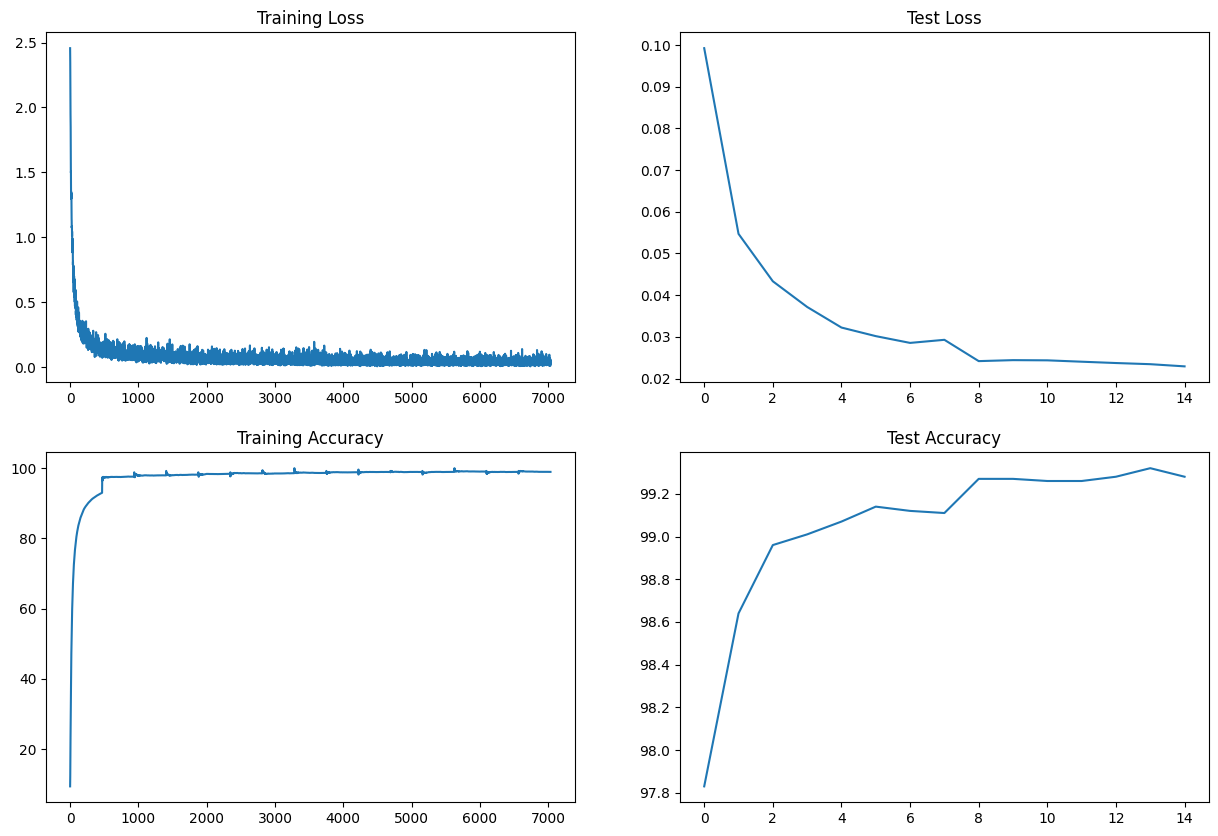

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
t = [t_items.item() for t_items in train_losses]
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

**Target:**

Add Image augmentation techniques such as Rotation, Translation, Scaling, etc.

**Results:**

Parameters: 7.3k

Best Train Accuracy: 98.97

Best Test Accuracy: 99.46

**Analysis:**

The model is under-fitting now. This is fine, as we know we have made our training data harder.

The test accuracy is also up, which means our test data had few images that had transformation difference w.r.t. train dataset